In [1]:
# %env TRANSFORMERS_CACHE=/mnt/LLM/hub
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import time
import random
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

/home/galqiwi/miniconda-eval/envs/eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MODEL_PATH = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MODEL_SEQLEN=2048

In [4]:
from eval import *

testloader = get_loaders(
    'wikitext2',
    seed=0,
    model_path=MODEL_PATH,
    seqlen=MODEL_SEQLEN,
    eval_mode=True,
    use_fast_tokenizer=False,
    trust_remote_code=False,
)

def eval_ppl(
    model,
    model_path,
    model_seqlen,
    device = 'cuda:0',
    # ppl_datasets = ('wikitext2',),
    trust_remote_code=False,
    offload_activations=False,
):
    output = {}
    
    ppl = perplexity_eval(
        model,
        testloader,
        dataset_name='wikitext2',
        model_seqlen=model_seqlen,
        device=device,
        offload_activations=offload_activations,
    )
    output['wikitext2'] = ppl
    # make sure that the cache is released
    torch.cuda.empty_cache()
    
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (341469 > 2048). Running this sequence through the model will result in indexing errors


In [5]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
).cuda()

In [6]:
eval_ppl(model, MODEL_PATH, model_seqlen=MODEL_SEQLEN, device='cuda:0')

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.45 `position_ids` will be removed and `position_embeddings` will be mandatory.


{'wikitext2': 7.972210884094238}

In [7]:
baseline_ppl = eval_ppl(model, MODEL_PATH, model_seqlen=MODEL_SEQLEN, device='cuda:0')['wikitext2']

In [8]:
import copy

In [9]:
import torch

class NoisyLinear(torch.nn.Module):
    def __init__(self, weight, bias, *, relative_mse = 0):
        super().__init__()

        weight = weight.detach().clone()
        if bias is not None:
            bias = bias.detach().clone()

        self.out_features, self.in_features = weight.shape

        self.inner = torch.nn.Linear(
            self.in_features, self.out_features, bias=(bias is not None),
            dtype=weight.dtype, device=weight.device,
        )

        weight = weight + torch.randn_like(weight) * torch.norm(weight) * (relative_mse ** 0.5) / (weight.numel() ** 0.5)

        self.inner.weight.data = weight
        if bias is not None:
            self.inner.bias.data = bias

    def forward(self, input):
        return self.inner(input)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

In [10]:
PATH = 'model.layers.0.mlp.down_proj'

In [11]:
def add_noise(model, path, relative_mse):
    parent = get_module_by_path(model, '.'.join(path.split('.')[:-1]))
    
    child = get_module_by_path(model, path)
    assert isinstance(child, torch.nn.Linear)
    
    new_linear = NoisyLinear(child.weight, child.bias, relative_mse=relative_mse)
    setattr(parent, path.split('.')[-1], new_linear)

In [12]:
def get_noisy_ppl(path, relative_mse):
    noisy_model = copy.deepcopy(model)
    add_noise(noisy_model, path, relative_mse)
    return eval_ppl(noisy_model, MODEL_PATH, model_seqlen=MODEL_SEQLEN, device='cuda:0')['wikitext2']

100%|███████████████████████████████████████████| 20/20 [17:45<00:00, 53.26s/it]


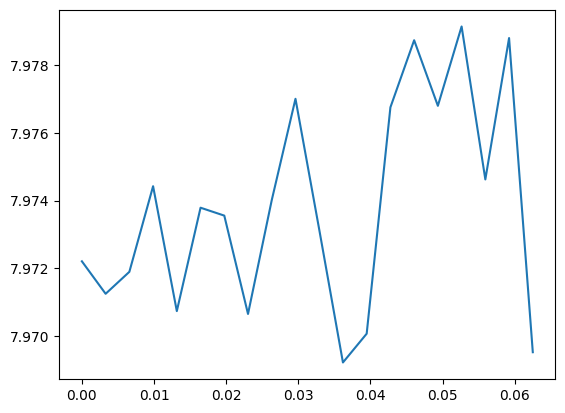

In [13]:
import matplotlib.pyplot as plt
import tqdm

grid = np.linspace(0, 4 ** -2, 20)
ppls = [get_noisy_ppl(PATH, mse) for mse in tqdm.tqdm(grid)]
plt.plot(grid, ppls)